In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.multiclass import OneVsRestClassifier

from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

import scikitplot as skplt
from pprint import pprint


Using TensorFlow backend.
C:\Users\yuka\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\yuka\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\yuka\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\yuka\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529

In [2]:
df_r = pd.read_csv("data/df_resampled.csv")
df_r

,gps_height,longitude,latitude,population,basin_Internal,basin_Lake_Nyasa,basin_Lake_Rukwa,basin_Lake_Tanganyika,basin_Lake_Victoria,basin_Pangani,...,funder_group_gov,funder_group_hesewa,funder_group_kkkt,funder_group_others,funder_group_rwe,funder_group_tcrs,funder_group_unknown,population_zero_0,population_zero_1,status_group
0,2.045055,0.110766,0.501897,-0.042229,1,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,functional
1,0.373597,0.143490,-0.006287,-0.381587,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,functional
2,-0.126055,-1.028468,-1.145688,-0.381587,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,1,non functional
3,-0.126055,-0.420876,-1.060482,-0.381587,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,non functional
4,-0.074504,0.736288,-0.113630,-0.127068,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,non functional
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61954,-0.126055,1.437858,0.280064,0.176710,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,non functional
61955,-0.126055,-0.877940,-1.167614,-0.381587,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,1,non functional
61956,-0.126055,-0.844502,-1.203330,-0.381587,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,non functional
61957,-2.019432,1.499206,-0.576637,0.508375,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,non functional


In [3]:
# Split X and y 

X_train_resampled = df_r.iloc[0:61959,0:110]
y_train_resampled = df_r[["status_group"]]


In [5]:
print(len(X_train_resampled))
print(len(y_train_resampled))
print(y_train_resampled.status_group.value_counts())

61959
61959
functional                 20653
non functional             20653
functional needs repair    20653
Name: status_group, dtype: int64


In [6]:
df = pd.read_csv("data/resampled_tanzania_cleaned_df.csv")
df.shape

(59400, 111)

In [7]:
# Feature selection 
X = df.iloc[0:59400,0:110]
y= df[['status_group']]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=42)

In [9]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))
print(df.status_group.value_counts())

47520
47520
11880
11880
functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64


# 1. Baseline model + resampled X,y trainsets + Train test split cross validation

In [10]:
def modeling(clf,X_train,y_train,X_test,y_test):
    """returns train a model and return model's accuracy and F1_macro"""
    
    clf.fit(X_train,y_train)
    y_pred =clf.predict(X_test)
    clf_report = classification_report(y_test,y_pred)
    clf_acc_score = accuracy_score(y_test, y_pred)
    f1score=f1_score(y_test, y_pred, average='macro')
    return  clf_report, clf_acc_score, f1score
    print(clf_report)

In [12]:
XGB =XGBClassifier()
XGB_clf_report, XGB_clf_acc_score, XGB_f1score = modeling(XGB,X_train_resampled,y_train_resampled,X_test,y_test)

In [13]:
print(XGB_clf_report)

                         precision    recall  f1-score   support

             functional       0.88      0.88      0.88      6457
functional needs repair       0.54      0.69      0.60       851
         non functional       0.89      0.84      0.86      4572

               accuracy                           0.85     11880
              macro avg       0.77      0.80      0.78     11880
           weighted avg       0.86      0.85      0.85     11880



In [14]:
pprint(XGB.get_params())

{'base_score': 0.5,
 'booster': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': None,
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'objective': 'multi:softprob',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': None,
 'subsample': 1,
 'tree_method': None,
 'validate_parameters': False,
 'verbosity': None}


# 2 Gridsearch hyperparamters + resampled X,y train + kfold Cross validation( XGB ) 


In [15]:
# kfold 5 or 3 

kf = KFold(n_splits=3, random_state=42, shuffle=False)

C:\Users\yuka\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [17]:
params_xgb = {#'n_estimators': [100],
               'max_depth': [6,8,10],
               #'validate_parameters': [True],
               #'min_child_weight': [1],
               'gamma':[0, 0.5],
               #'learning_rate':[0.05,0.3],
               #'colsample_bytree':[1,0.5]
}

In [18]:
grid_no_up = GridSearchCV(XGB, param_grid=params_xgb, cv=kf, 
                          scoring='f1_macro').fit(X_train_resampled,y_train_resampled)

In [19]:
print(grid_no_up.best_score_)
print(grid_no_up.best_params_)
print(f1_score(y_test, grid_no_up.predict(X_test),average='macro'))

0.7677809311621616
{'gamma': 0, 'max_depth': 10}
0.7946541169126066


In [20]:
print(grid_no_up.cv_results_)

{'mean_fit_time': array([ 65.38323493,  92.19549599, 115.44864416,  72.82925477,
        88.24316583, 117.76127148]), 'std_fit_time': array([3.22732101, 2.89217359, 2.60071691, 4.80337583, 3.62622257,
       7.25929304]), 'mean_score_time': array([0.37104158, 0.45614796, 0.49911747, 0.36817865, 0.37483253,
       0.44178276]), 'std_score_time': array([0.03630365, 0.09040261, 0.08385511, 0.02863257, 0.0068119 ,
       0.04551088]), 'param_gamma': masked_array(data=[0, 0, 0, 0.5, 0.5, 0.5],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_max_depth': masked_array(data=[6, 8, 10, 6, 8, 10],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'gamma': 0, 'max_depth': 6}, {'gamma': 0, 'max_depth': 8}, {'gamma': 0, 'max_depth': 10}, {'gamma': 0.5, 'max_depth': 6}, {'gamma': 0.5, 'max_depth': 8}, {'gamma': 0.5, 'max_depth': 10}], 'split0_test_score': ar

In [21]:
grid_no_up = GridSearchCV(XGB, param_grid=params_xgb, cv=kf, 
                          scoring='accuracy').fit(X_train_resampled, y_train_resampled)

In [22]:
print(grid_no_up.best_score_)
print(grid_no_up.best_params_)
print(f1_score(y_test, grid_no_up.predict(X_test),average='macro'))

0.8926389270018811
{'gamma': 0, 'max_depth': 10}
0.7946541169126066


In [23]:
print(grid_no_up.cv_results_)

{'mean_fit_time': array([ 66.6924561 ,  87.71321931, 102.13323116,  63.75542521,
        81.18096228, 146.47257895]), 'std_fit_time': array([ 2.32568961,  4.67676284,  2.03034762,  0.97795595,  0.60364417,
       82.4841049 ]), 'mean_score_time': array([0.26413302, 0.27972479, 0.30349636, 0.25008626, 0.29193482,
       0.31143703]), 'std_score_time': array([0.0059026 , 0.00314278, 0.00598403, 0.00639078, 0.03681141,
       0.01243396]), 'param_gamma': masked_array(data=[0, 0, 0, 0.5, 0.5, 0.5],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_max_depth': masked_array(data=[6, 8, 10, 6, 8, 10],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'gamma': 0, 'max_depth': 6}, {'gamma': 0, 'max_depth': 8}, {'gamma': 0, 'max_depth': 10}, {'gamma': 0.5, 'max_depth': 6}, {'gamma': 0.5, 'max_depth': 8}, {'gamma': 0.5, 'max_depth': 10}], 'split0_test_scor

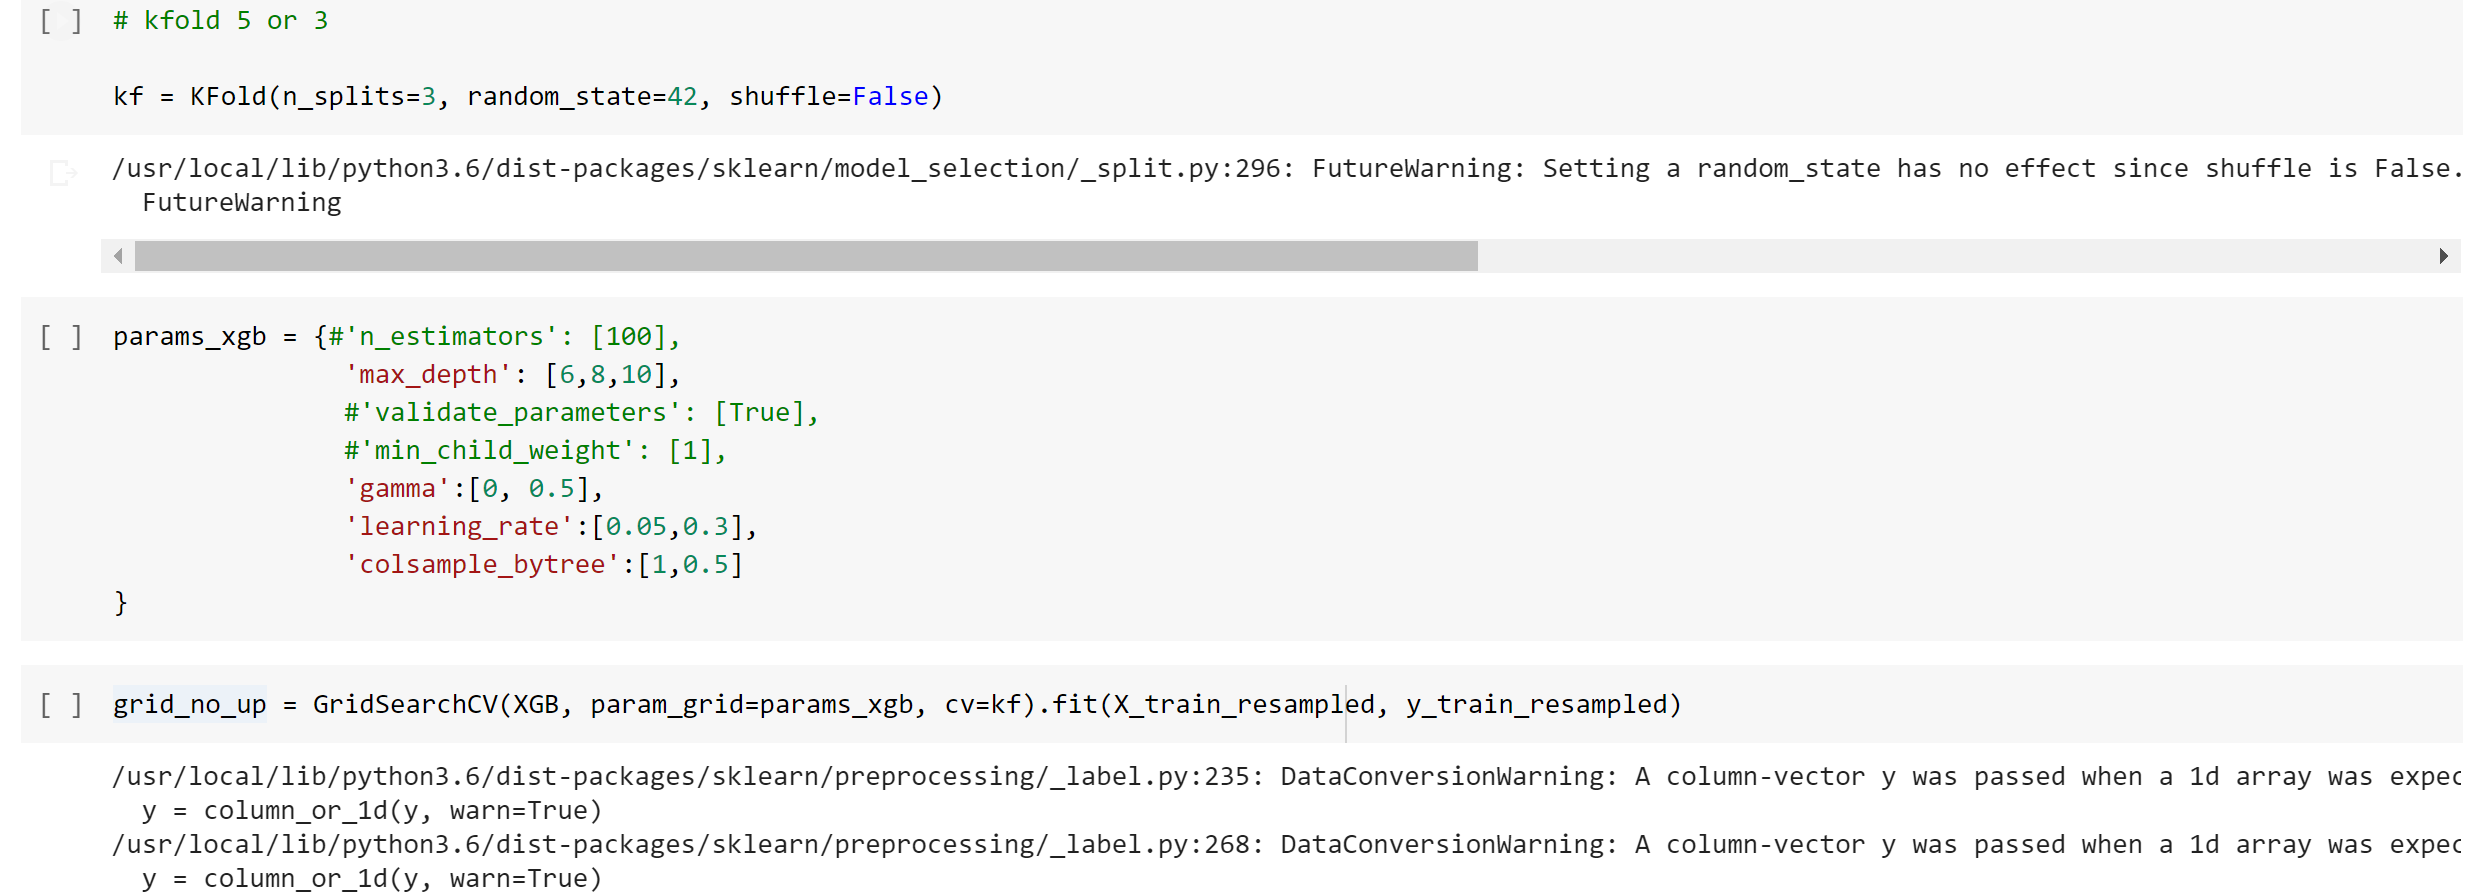

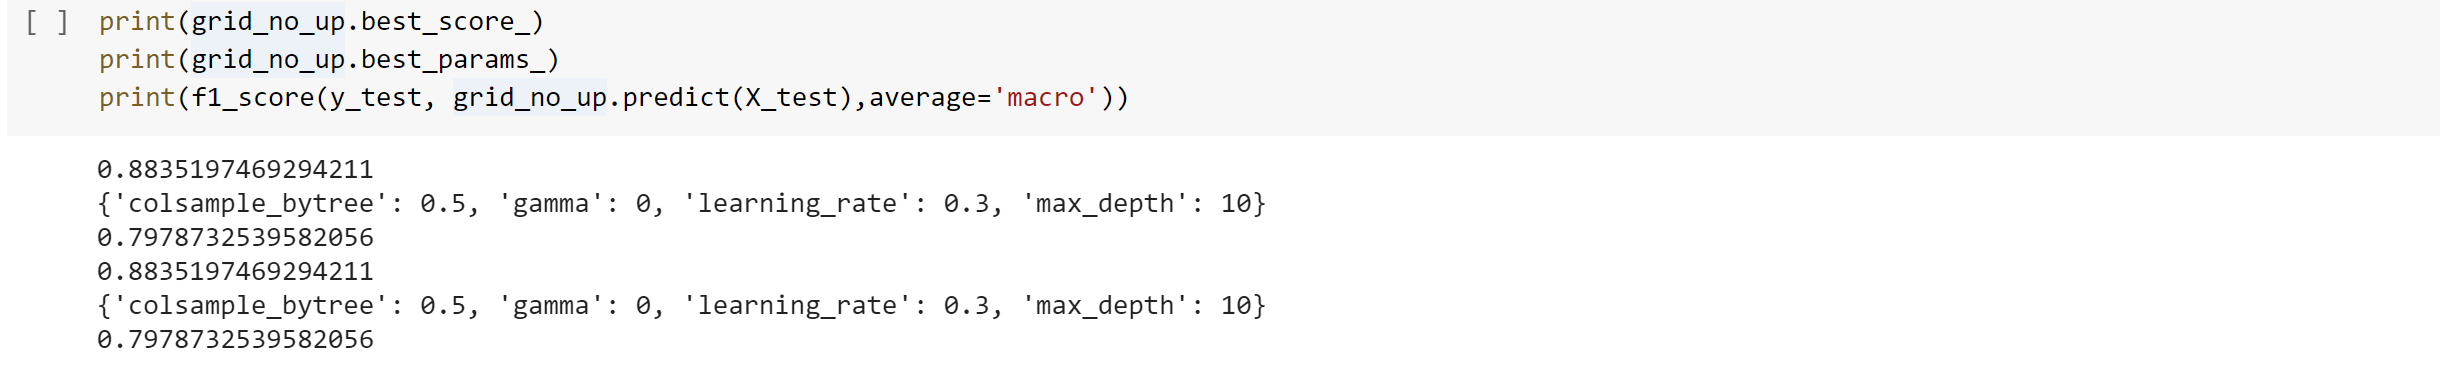

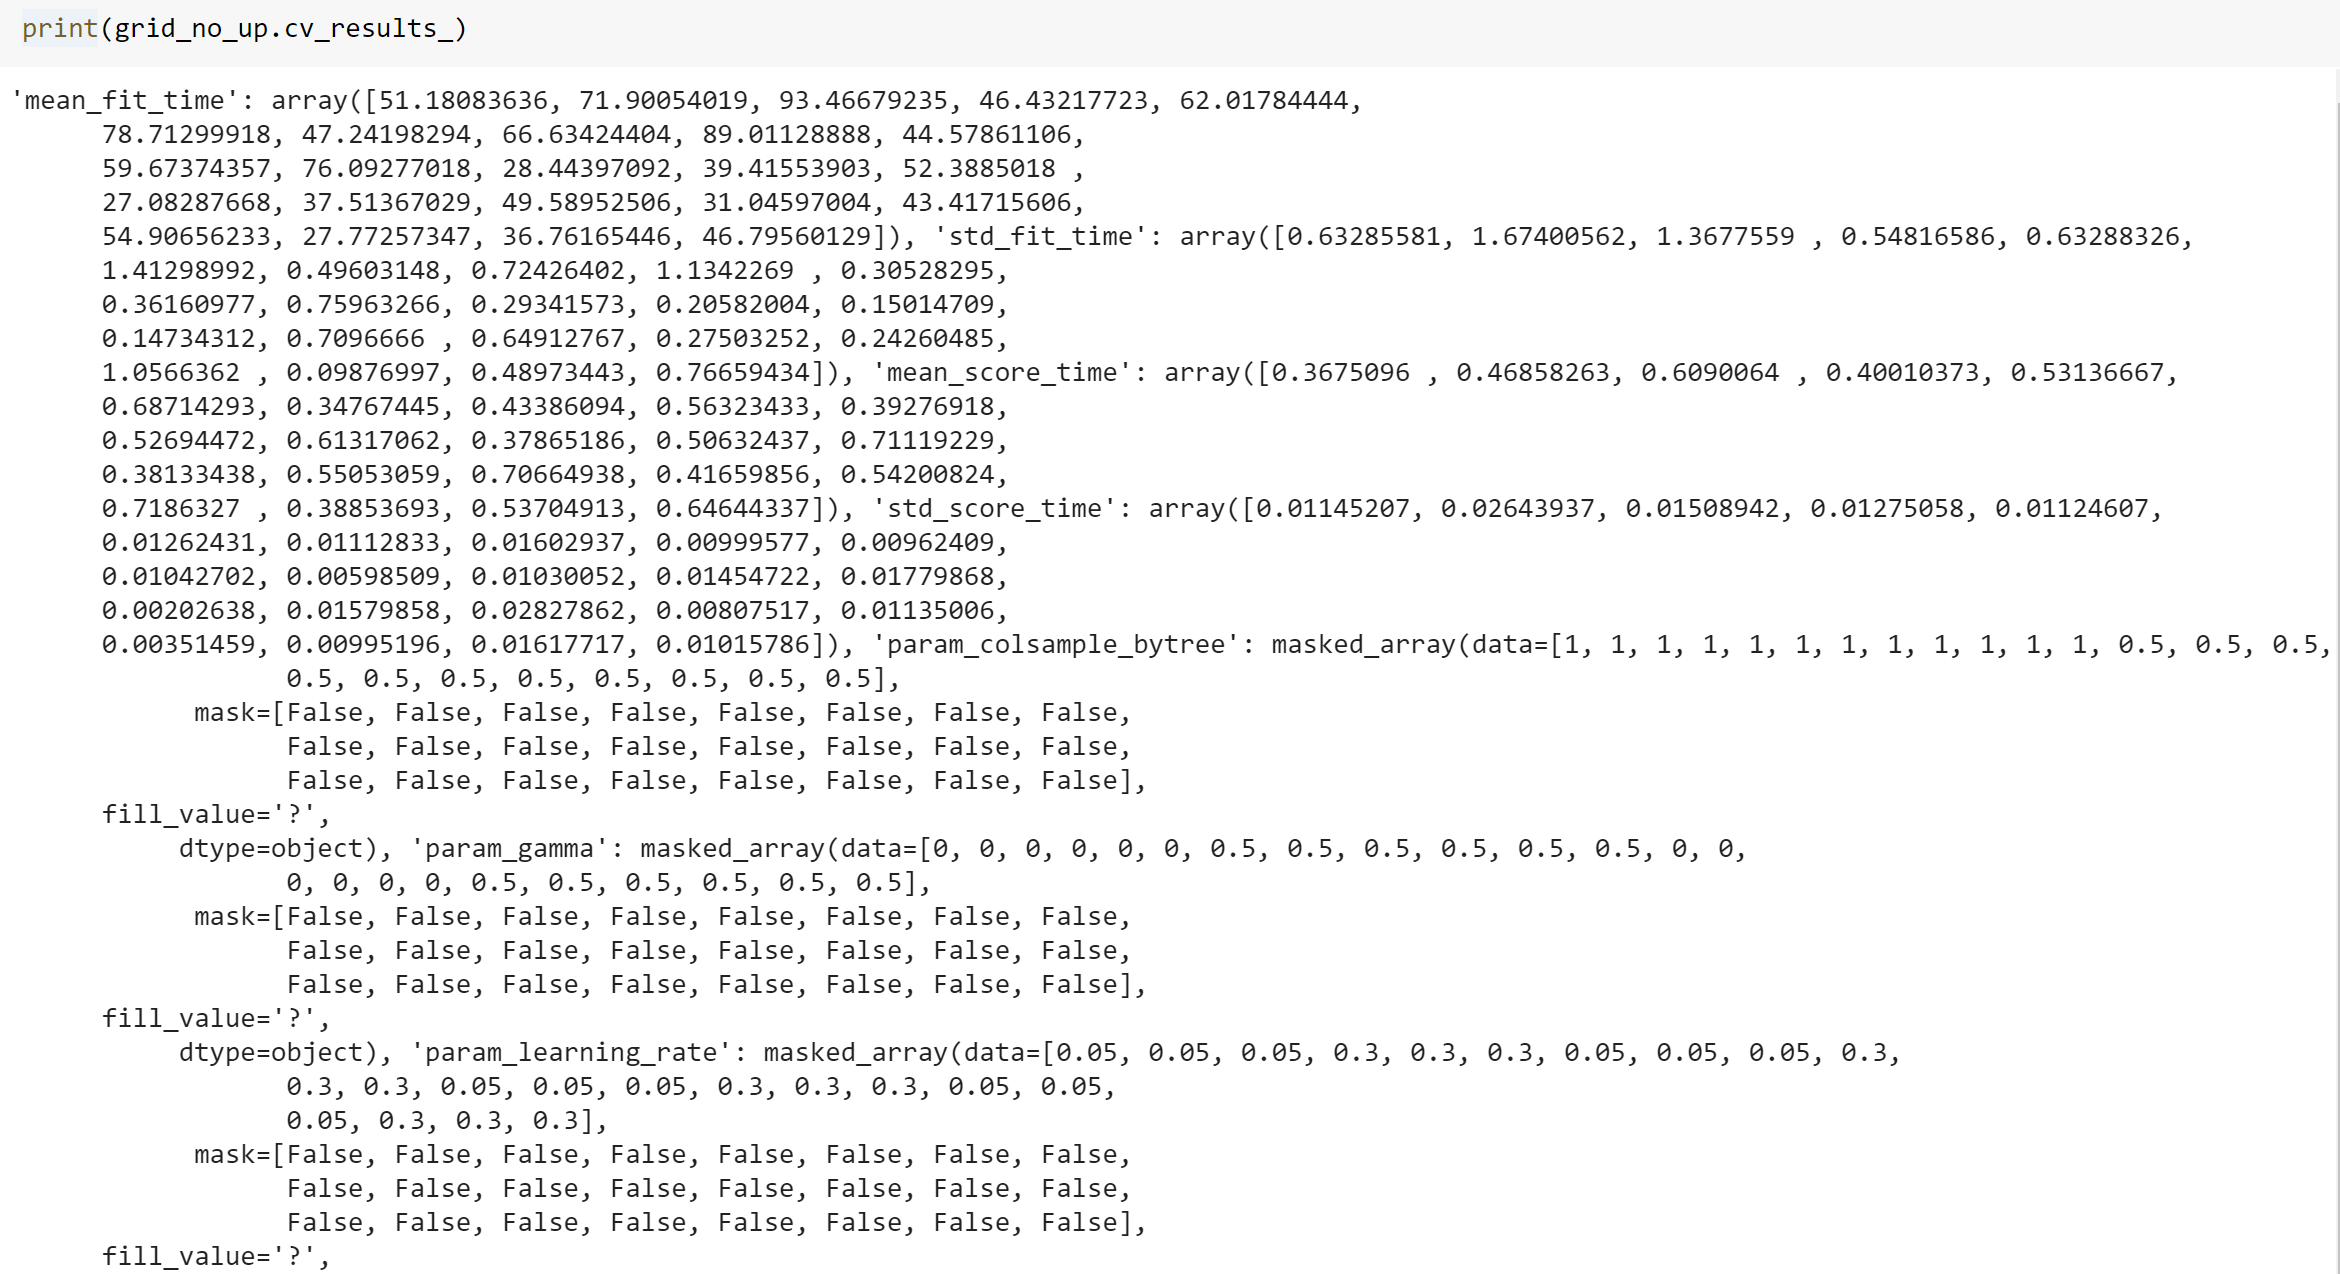

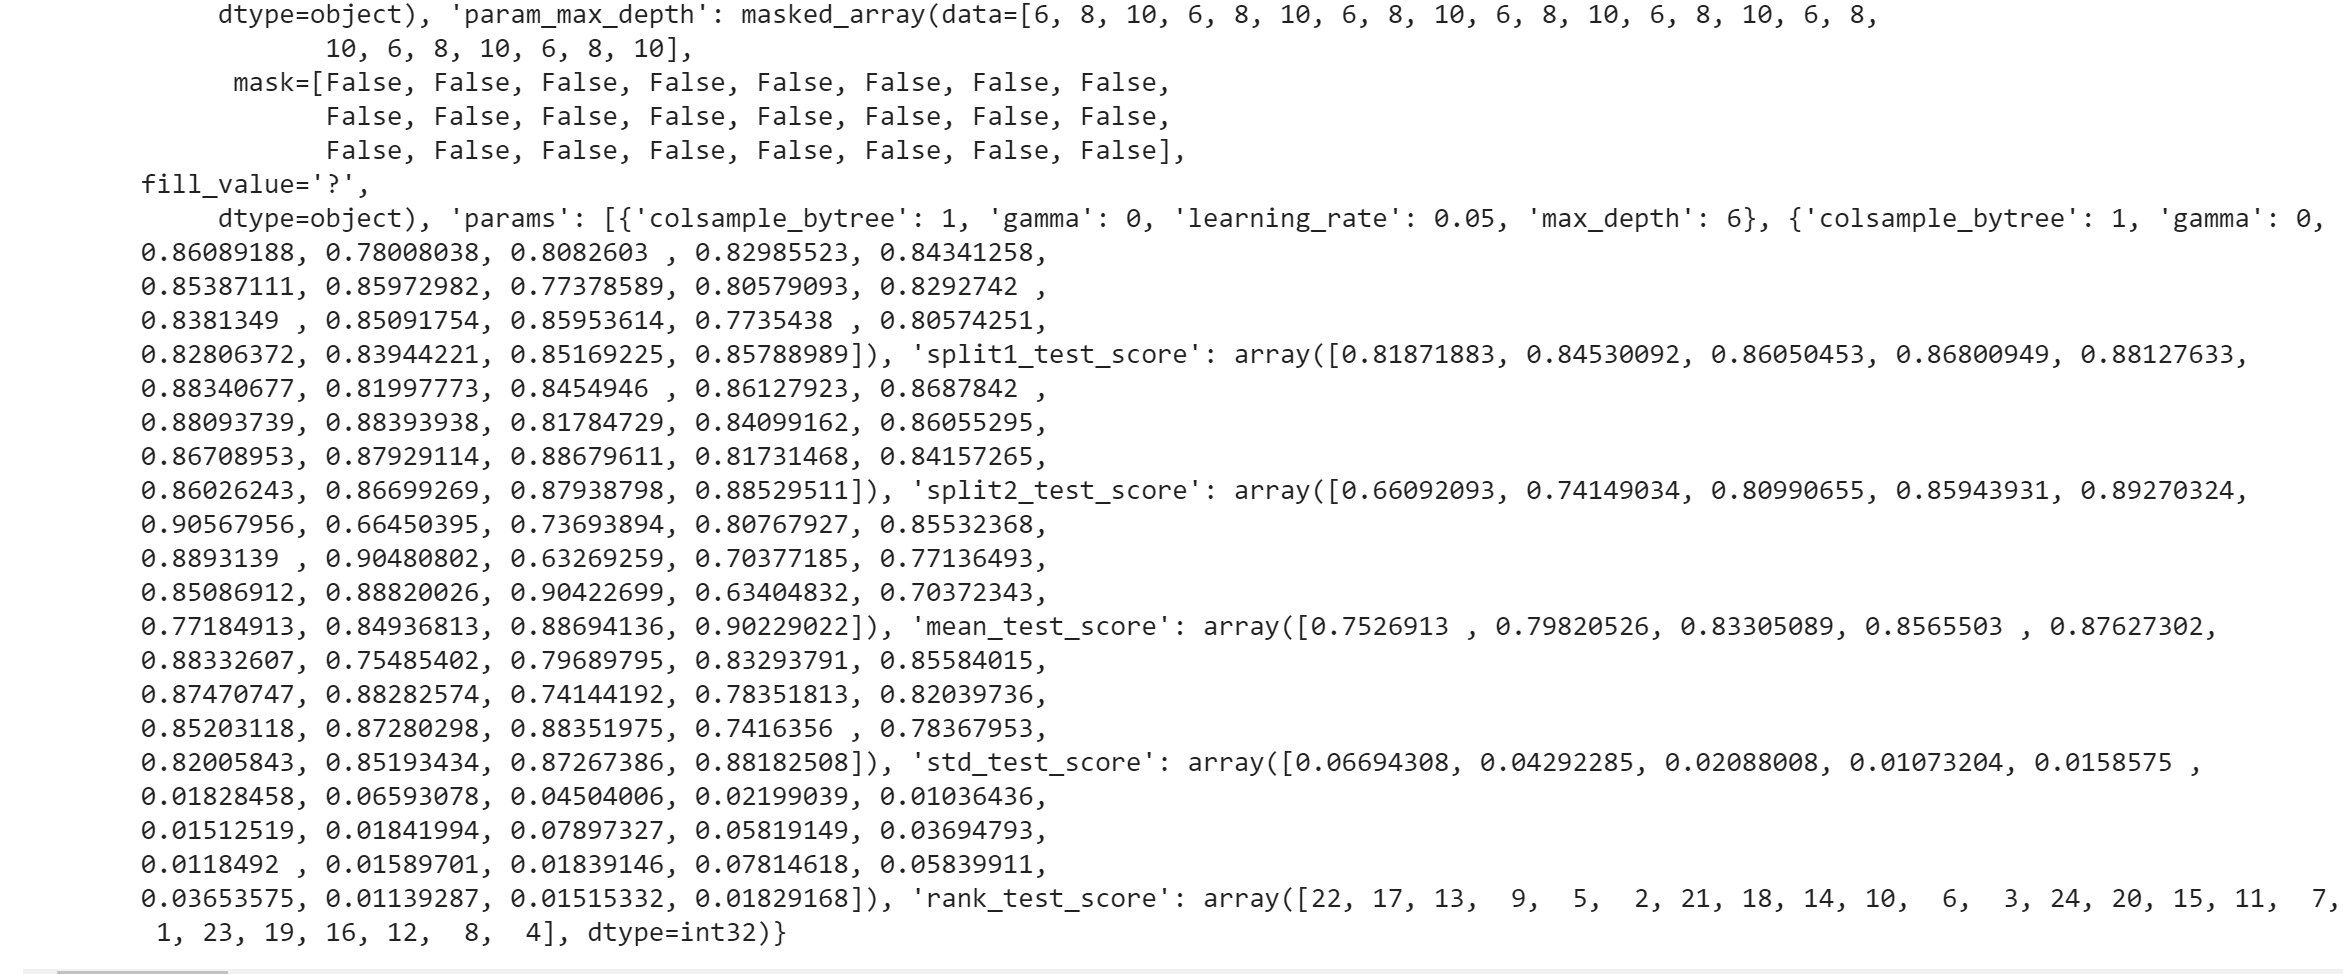